# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [11]:
#sorting of data
final['Time'] = pd.to_datetime(final['Time'])
# Sort by time
final = final.sort_values(by='Time')

print(final.shape)
print(final['Score'].value_counts())

print(final['Text'][1])

(364173, 10)
1    307063
0     57110
Name: Score, dtype: int64
Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".


<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [15]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1970-01-01 00:00:00.939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1970-01-01 00:00:00.940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1970-01-01 00:00:00.944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1970-01-01 00:00:00.944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,1970-01-01 00:00:00.946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I finally ordered a couple products from this seller for myself(not as gifts) and I am really happy. This Jade Bonsai is really cool and it arrived fast and in perfect condition. It's in my living room and I get tons of compliments. It's already grown some too and the pot it came in is really nice, looks expensive! Much bigger than I thought it would be even.  Thanks again!!
I bought some of this tea when I was in Seattle and I have been dying to get more.  It really is the best tea I have ever had.  It is great hot or cold.
I would prefer freshly made brown rice, but that takes a long time to make and isn't easy. Th

In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [18]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I finally ordered a couple products from this seller for myself(not as gifts) and I am really happy. This Jade Bonsai is really cool and it arrived fast and in perfect condition. It's in my living room and I get tons of compliments. It's already grown some too and the pot it came in is really nice, looks expensive! Much bigger than I thought it would be even.  Thanks again!!
I bought some of this tea when I was in Seattle and I have been dying to get more.  It really is the best tea I have ever had.  It is great hot or cold.
I would prefer freshly made brown rice, but that takes a long time to make and isn't easy. Th

In [19]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I bought some of this tea when I was in Seattle and I have been dying to get more.  It really is the best tea I have ever had.  It is great hot or cold.


In [21]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [22]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I bought some of this tea when I was in Seattle and I have been dying to get more It really is the best tea I have ever had It is great hot or cold 


In [23]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [03:18<00:00, 1837.68it/s]


In [25]:
# Random sampling
data = final.head(100000)

data_preprocessed_reviews=preprocessed_reviews[0:100000]

In [26]:
print("The size of sampled data is ",data.shape)
print("The size of sampled data is ",len(data_preprocessed_reviews))

The size of sampled data is  (100000, 10)
The size of sampled data is  100000


# [4] Featurization

## [4.1] BAG OF WORDS

In [29]:
# Spliting into Train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_preprocessed_reviews,data['Score'].values,test_size=0.3,shuffle=False)

In [30]:
#Bag of words
count_vect = CountVectorizer(max_features=2000, min_df=20) 

x_train = count_vect.fit_transform(x_train)



x_test = count_vect.transform(x_test)



Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  8.3min finished


Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=9, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
Best Score: 88.69%
Best HyperParameter:  {'max_depth': 9, 'n_estimators': 500}


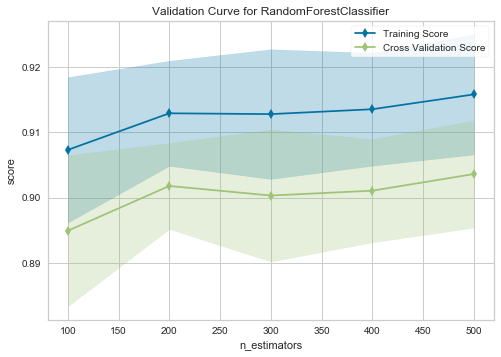

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from yellowbrick.model_selection import ValidationCurve

base_learners = [100,200,300,400,500]
depth = (range(1,20,4))
param_grid={"n_estimators":base_learners,"max_depth":depth}
tscv = TimeSeriesSplit(n_splits=5)
rf = RandomForestClassifier(max_features='sqrt', class_weight="balanced")
gsv = GridSearchCV(rf, param_grid,scoring='roc_auc',cv=tscv,n_jobs=-1,verbose=1)
gsv.fit(x_train, y_train)
cv_scores = gsv.cv_results_['mean_test_score']
print("Model with best parameters :\n",gsv.best_estimator_)
print("Best Score: %.2f%%"%(gsv.best_score_*100))
print("Best HyperParameter: ",gsv.best_params_)
optimal_n_estimators = gsv.best_estimator_.n_estimators
optimal_max_depth = gsv.best_estimator_.max_depth

#Validation Curve
viz = ValidationCurve(gsv.best_estimator_, param_name="n_estimators",param_range=base_learners, cv=tscv, scoring='f1')
viz.fit(x_train, y_train)
viz.poof()

In [36]:
gsv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=9, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

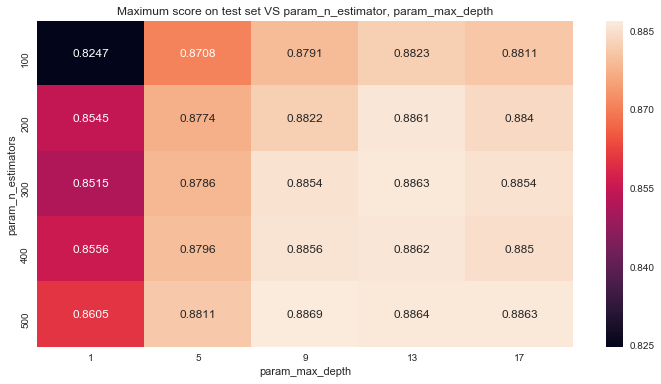

In [37]:
df_gridsearch = pd.DataFrame(gsv.cv_results_)
max_scores = df_gridsearch.groupby(['param_n_estimators','param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)
title = 'Maximum score on test set VS param_n_estimator, param_max_depth'
fmt = 'png'
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');
plt.title(title);

In [40]:
# This function plots the confusion, precision and recall matrices
def plot_confusion_matrix(x_test, y_pred):
    C = confusion_matrix(x_test, y_pred)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()


The optimal value of n_estimators is :  500
The optimal value of max_depth is :  9
ROC_AUC on test set: 0.895
Accuracy on test set: 81.930%
Precision on test set: 0.961
Recall on test set: 0.824
F1-Score on test set: 0.887


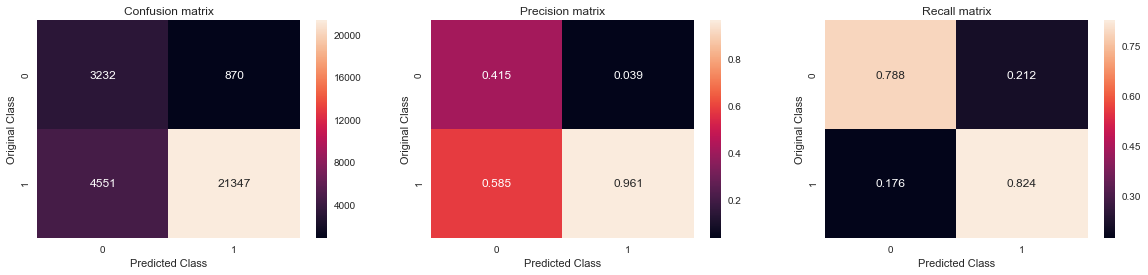

In [43]:
#Testing Accuracy on Test data
#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score



#Testing Accuracy on Test data
print("The optimal value of n_estimators is : ",optimal_n_estimators)
print("The optimal value of max_depth is : ",optimal_max_depth)
rf = RandomForestClassifier(n_estimators=optimal_n_estimators, max_depth=optimal_max_depth, max_features='sqrt', class_weight="balanced")
rf.fit(x_train,y_train)
y_pred = rf.predict(x_test)
y_prob = rf.predict_proba(x_test)


print("ROC_AUC on test set: %0.3f" % roc_auc_score(y_test, y_prob[:,1]))
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

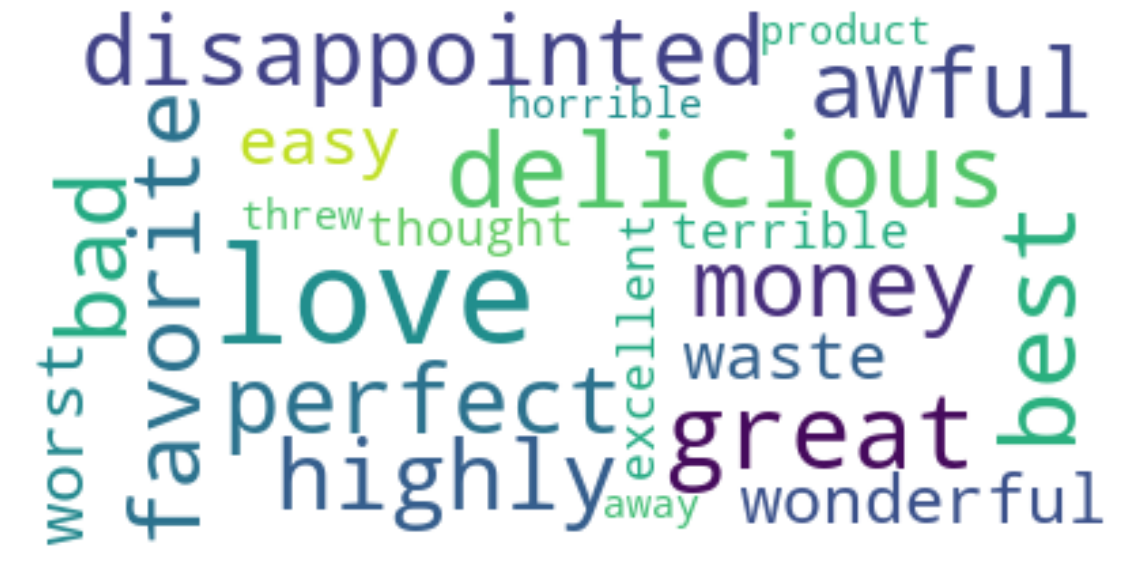

In [46]:
#https://www.datacamp.com/community/tutorials/wordcloud-python
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

importances=rf.feature_importances_
feat_names=count_vect.get_feature_names()

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:25]
a=np.take(feat_names,indices)
def words(X):
    comment_words=' '
    for words in X: 
        comment_words = comment_words + words + ' '
    return comment_words
a=words(a)

#Word Cloud
wc = WordCloud(max_font_size=50, max_words=100, background_color="white")
wc.generate(a)
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from yellowbrick.model_selection import ValidationCurve

base_learners = [200,300,400,500,600,700]
Depths = [1,3,5,7,9,11,15]
Learning_rate = [0.01,0.05,0.1,0.2,0.3,0.5]

param_grid = {'n_estimators': base_learners, 'max_depth':Depths, 'learning_rate':Learning_rate}
tscv = TimeSeriesSplit(n_splits=5)
gb = GradientBoostingClassifier(max_features='sqrt')
gsv = GridSearchCV(gb, param_grid,scoring='roc_auc',cv=tscv,n_jobs=-1,verbose=1)
gsv.fit(x_train, y_train)
cv_scores = gsv.cv_results_['mean_test_score']
print("Model with best parameters :\n",gsv.best_estimator_)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
optimal_n_estimators = gsv.best_estimator_.n_estimators
optimal_max_depth = gsv.best_estimator_.max_depth
optimal_learning_rate = gsv.best_estimator_.learning_rate

#Validation Curve
viz = ValidationCurve(gsv.best_estimator_, param_name="n_estimators",param_range=base_learners, cv=tscv, scoring='f1')
viz.fit(X_train, y_train)
viz.poof()

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.2min


## [4.2] Bi-Grams and n-Grams.

In [38]:
# Spliting into Train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_preprocessed_reviews,data['Score'].values,test_size=0.3,shuffle=False)


#Bag of words
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=2000)


x_train = count_vect.fit_transform(x_train)
print("the type of count vectorizer for train data is ",type(x_train))
print("the shape of train data vectorizer is ",x_train.get_shape())
print("the number of unique words including both unigrams and bigrams for train data is ", x_train.get_shape()[1])


x_test = count_vect.transform(x_test)
print("the type of count vectorizer for test data is ",type(x_test))
print("the shape of test data vectorizer is ",x_test.get_shape())
print("the number of unique words including both unigrams and bigrams for test data is ", x_test.get_shape()[1])



the type of count vectorizer for train data is  <class 'scipy.sparse.csr.csr_matrix'>
the shape of train data vectorizer is  (70000, 2000)
the number of unique words including both unigrams and bigrams for train data is  2000
the type of count vectorizer for test data is  <class 'scipy.sparse.csr.csr_matrix'>
the shape of test data vectorizer is  (30000, 2000)
the number of unique words including both unigrams and bigrams for test data is  2000


In [39]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

depth=[1,5,10,50,100,500,1000]
min_split=[5,10,100,500]
clf = DecisionTreeClassifier(class_weight='balanced')
param_grid = {'max_depth': depth,'min_samples_split': min_split}
tscv = TimeSeriesSplit(n_splits=5) #For time based splitting

gsv = GridSearchCV (clf,param_grid,cv=tscv,verbose=1,scoring='roc_auc',n_jobs=-1)
gsv.fit(x_train,y_train)
cv_scores = gsv.cv_results_['mean_test_score']

print("The best hyperparameter is : ",gsv.best_params_)
print("The best accuracy is : %.2f%%"%(gsv.best_score_*100))

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  5.6min finished


The best hyperparameter is :  {'max_depth': 50, 'min_samples_split': 500}
The best accuracy is : 78.97%


In [40]:
gsv.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=50, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

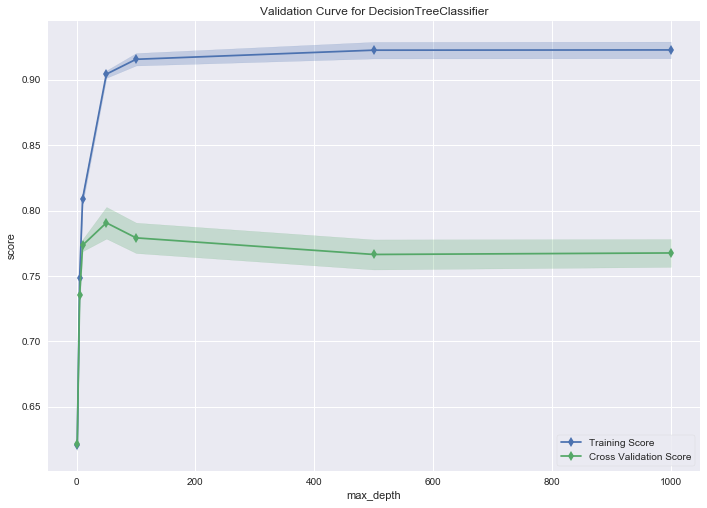

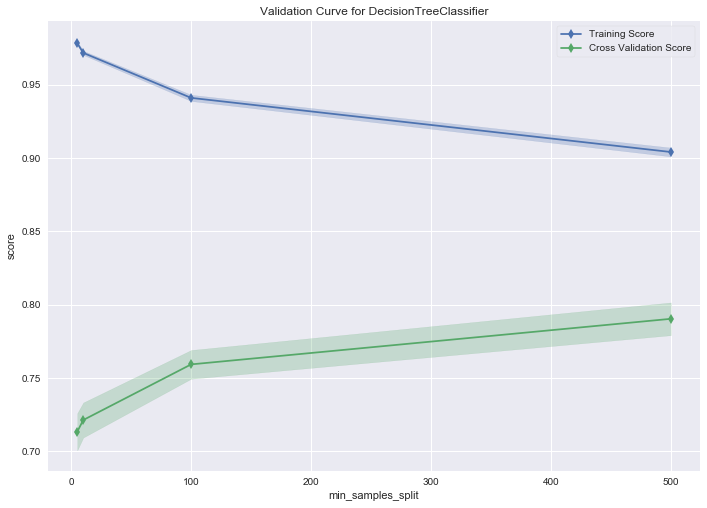

In [41]:
from yellowbrick.model_selection import ValidationCurve

#Validation Curve
viz = ValidationCurve(gsv.best_estimator_, param_name="max_depth",param_range=depth, cv=tscv, scoring="roc_auc")
viz.fit(x_train, y_train)
viz.poof()
viz = ValidationCurve(gsv.best_estimator_, param_name="min_samples_split",param_range=min_split, cv=tscv, scoring="roc_auc")
viz.fit(x_train, y_train)
viz.poof()

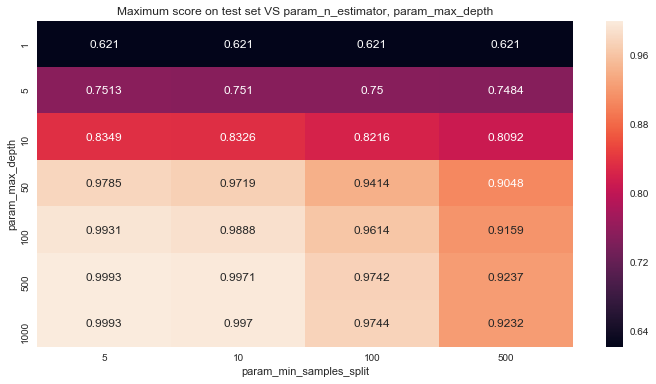

In [42]:
df_gridsearch = pd.DataFrame(gsv.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_min_samples_split']).max().unstack()[['mean_train_score']]
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)
title = 'Maximum score on test set VS param_n_estimator, param_max_depth'
fmt = 'png'
sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g');
plt.title(title);

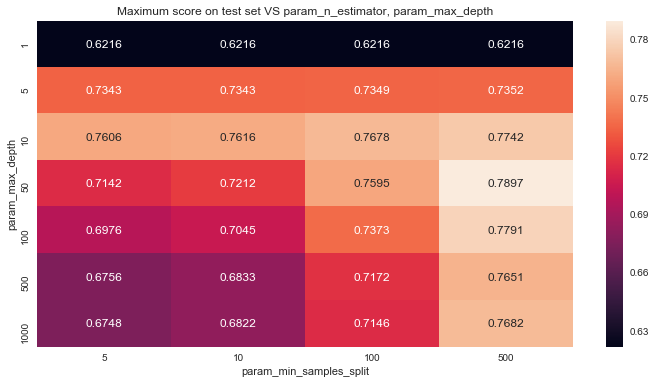

In [43]:
df_gridsearch = pd.DataFrame(gsv.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_min_samples_split']).max().unstack()[['mean_test_score']]
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)
title = 'Maximum score on test set VS param_n_estimator, param_max_depth'
fmt = 'png'
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');
plt.title(title);

ROC_AUC on test set: 0.838
Accuracy on test set: 87.937%
Precision on test set: 0.902
Recall on test set: 0.965
F1-Score on test set: 0.933


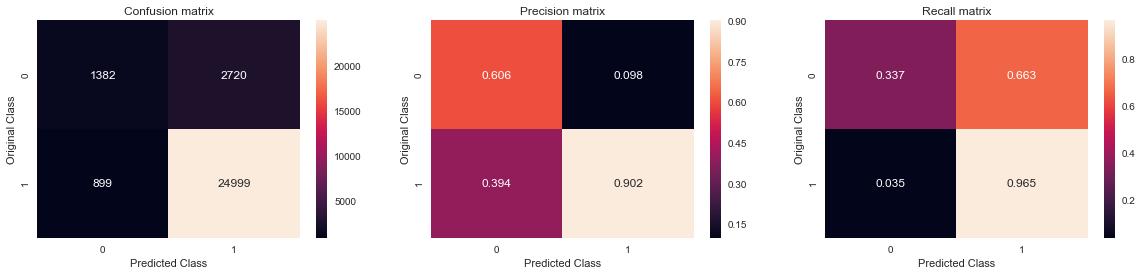

In [44]:
#Testing Accuracy on Test data
#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


clf = DecisionTreeClassifier(max_depth=50,min_samples_split=500)
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
y_prob = clf.predict_proba(x_test)


print("ROC_AUC on test set: %0.3f" % roc_auc_score(y_test, y_prob[:,1]))
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

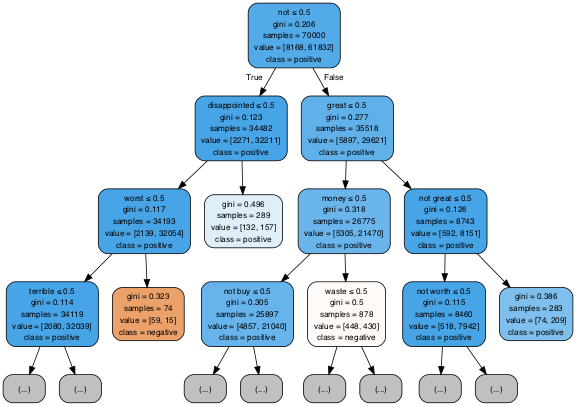

In [45]:
import graphviz 
from sklearn import tree
import pydotplus
from IPython.display import Image
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

target = ['negative','positive']
#Create DOT data
data1 = tree.export_graphviz(clf,out_file=None, max_depth=3, class_names=target,filled=True,rounded=True,special_characters=True, feature_names=count_vect.get_feature_names())
#Draw graph
graph = pydotplus.graph_from_dot_data(data1)  
#Show graph
graph.set_size('"6,6!"')
Image(graph.create_png())

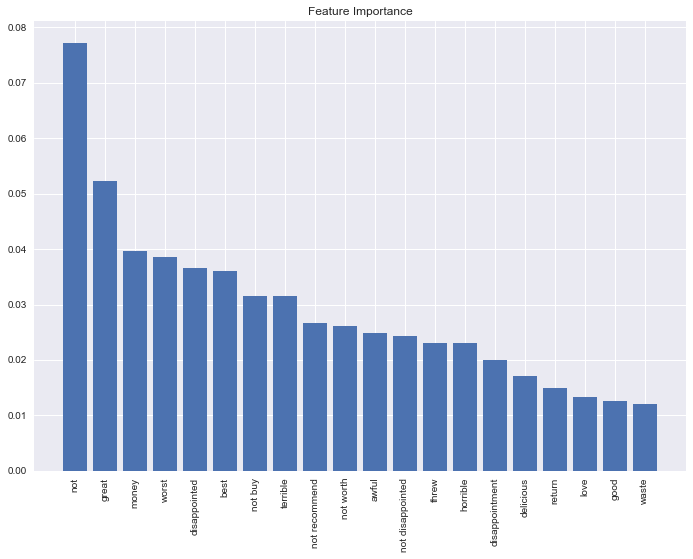

In [46]:
#feature importances from decision trees
importances = clf.feature_importances_

#Sort in descending order
indices = np.argsort(importances)[::-1][:20]

#Rearrange feature names so they match the sorted feature importances
names = count_vect.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})
#plot
plt.figure()
plt.title("Feature Importance")
plt.bar(range(20), importances[indices])
names = np.array(names)
plt.xticks(range(20), names[indices], rotation=90)
plt.show()

## [4.3] TF-IDF

In [47]:
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


# Spliting into Train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_preprocessed_reviews,data['Score'].values,test_size=0.3,shuffle=False)
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=2000, min_df=20) #Using bi-grams

#preparing the train data
x_train = tfidf.fit_transform(x_train)
#Normalize Data
x_train = preprocessing.normalize(x_train)
print("Train Data Size: ",x_train.shape)
print("the type of count vectorizer for train data is ",type(x_train))
print("the shape of train data is ",x_train.get_shape())
print("the number of unique words including both unigrams and bigrams for train data is ", x_train.get_shape()[1])
print("some sample features(unique words) ",tfidf.get_feature_names()[0:10])

#preparing the test data
x_test = tfidf.transform(x_test)
#Normalize Data
x_test = preprocessing.normalize(x_test)
print("Test Data Size: ",x_test.shape)
print("the type of count vectorizer for test data is ",type(x_test))
print("the shape of test data is ",x_test.get_shape())
print("the number of unique words including both unigrams and bigrams for test data is ", x_test.get_shape()[1])


Train Data Size:  (70000, 2000)
the type of count vectorizer for train data is  <class 'scipy.sparse.csr.csr_matrix'>
the shape of train data is  (70000, 2000)
the number of unique words including both unigrams and bigrams for train data is  2000
some sample features(unique words)  ['able', 'able find', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'according', 'acid', 'across', 'actual']
Test Data Size:  (30000, 2000)
the type of count vectorizer for test data is  <class 'scipy.sparse.csr.csr_matrix'>
the shape of test data is  (30000, 2000)
the number of unique words including both unigrams and bigrams for test data is  2000


In [48]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

depth=[1,5,10,50,100,500,1000]
min_split=[5,10,100,500]
clf = DecisionTreeClassifier(class_weight='balanced')
param_grid = {'max_depth': depth,'min_samples_split': min_split}
tscv = TimeSeriesSplit(n_splits=5) #For time based splitting

gsv = GridSearchCV (clf,param_grid,cv=tscv,verbose=1,scoring='roc_auc',n_jobs=-1)
gsv.fit(x_train,y_train)
cv_scores = gsv.cv_results_['mean_test_score']

print("The best hyperparameter is : ",gsv.best_params_)
print("The best accuracy is : %.2f%%"%(gsv.best_score_*100))

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  7.0min finished


The best hyperparameter is :  {'max_depth': 50, 'min_samples_split': 500}
The best accuracy is : 77.76%


In [49]:
gsv.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=50, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

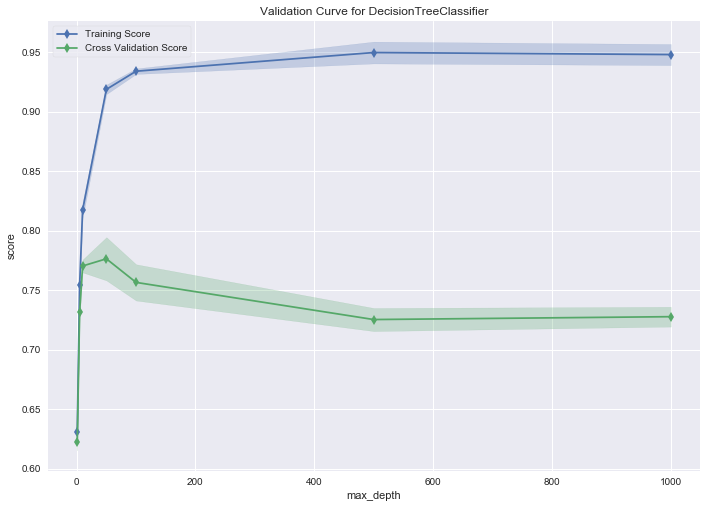

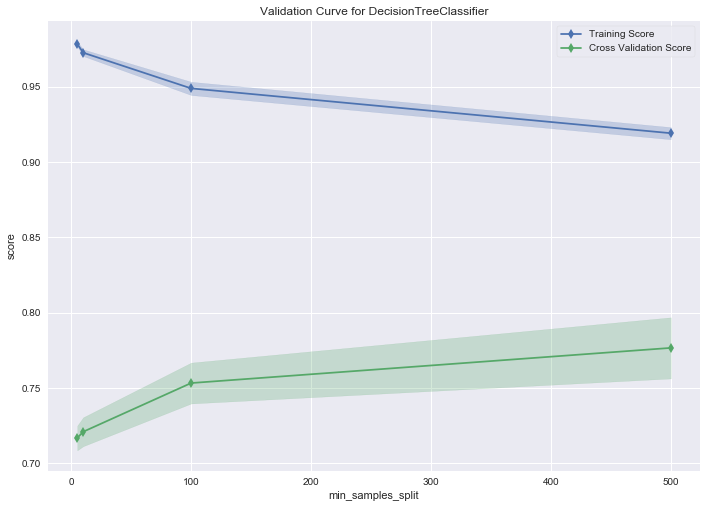

In [50]:
from yellowbrick.model_selection import ValidationCurve

#Validation Curve
viz = ValidationCurve(gsv.best_estimator_, param_name="max_depth",param_range=depth, cv=tscv, scoring="roc_auc")
viz.fit(x_train, y_train)
viz.poof()
viz = ValidationCurve(gsv.best_estimator_, param_name="min_samples_split",param_range=min_split, cv=tscv, scoring="roc_auc")
viz.fit(x_train, y_train)
viz.poof()

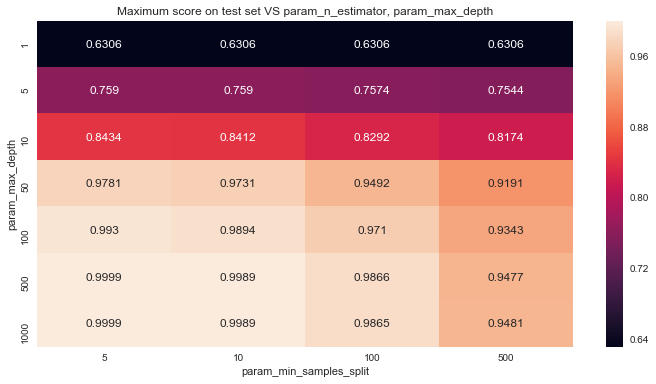

In [51]:
df_gridsearch = pd.DataFrame(gsv.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_min_samples_split']).max().unstack()[['mean_train_score']]
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)
title = 'Maximum score on test set VS param_n_estimator, param_max_depth'
fmt = 'png'
sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g');
plt.title(title);

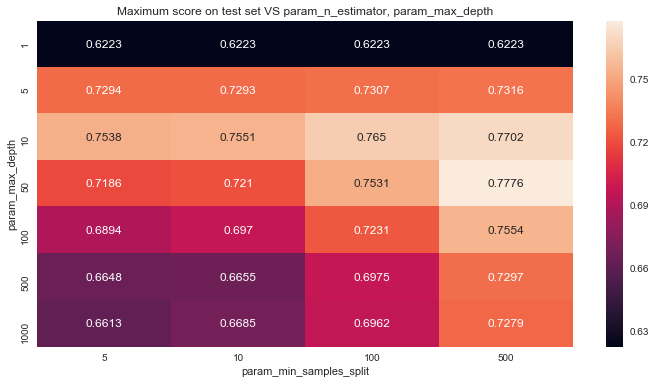

In [52]:
df_gridsearch = pd.DataFrame(gsv.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_min_samples_split']).max().unstack()[['mean_test_score']]
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)
title = 'Maximum score on test set VS param_n_estimator, param_max_depth'
fmt = 'png'
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');
plt.title(title);

ROC_AUC on test set: 0.819
Accuracy on test set: 87.617%
Precision on test set: 0.908
Recall on test set: 0.953
F1-Score on test set: 0.930


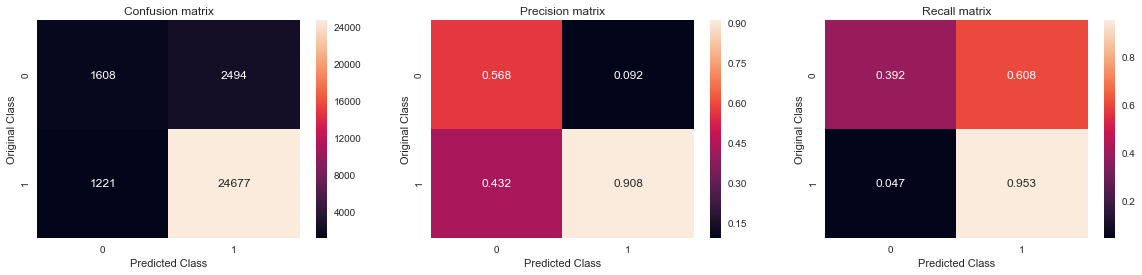

In [53]:
#Testing Accuracy on Test data
#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


clf = DecisionTreeClassifier(max_depth=50,min_samples_split=500)
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
y_prob = clf.predict_proba(x_test)


print("ROC_AUC on test set: %0.3f" % roc_auc_score(y_test, y_prob[:,1]))
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

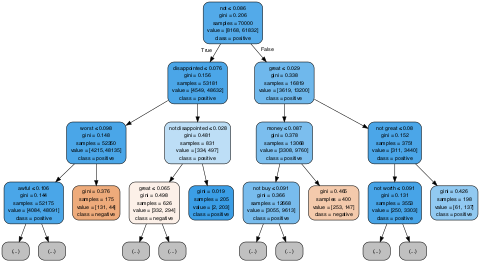

In [54]:
target = ['negative','positive']
#Create DOT data
data1 = tree.export_graphviz(clf,out_file=None, max_depth=3, class_names=target,filled=True,rounded=True,special_characters=True, feature_names=tfidf.get_feature_names())
#Draw graph
graph = pydotplus.graph_from_dot_data(data1)  
#Show graph
graph.set_size('"5,5!"')
Image(graph.create_png())

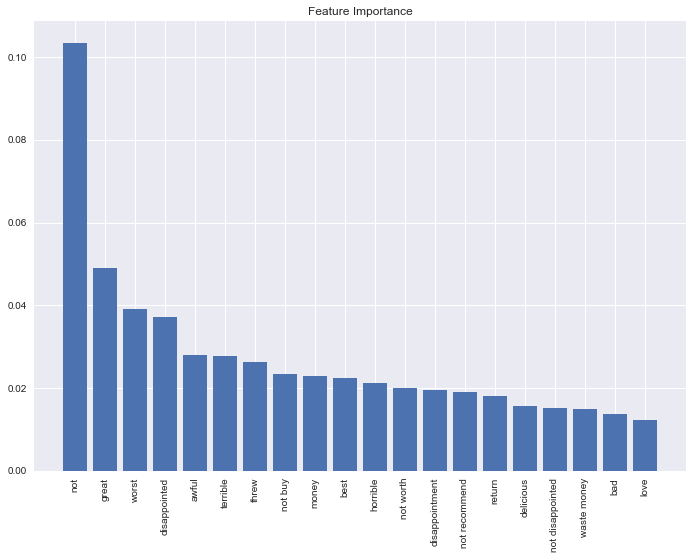

In [55]:
#feature importances from decision trees
importances = clf.feature_importances_

#Sort in descending order
indices = np.argsort(importances)[::-1][:20]

#Rearrange feature names so they match the sorted feature importances
names = count_vect.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})
#plot
plt.figure()
plt.title("Feature Importance")
plt.bar(range(20), importances[indices])
names = np.array(names)
plt.xticks(range(20), names[indices], rotation=90)
plt.show()

## [4.4] Word2Vec

In [56]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_preprocessed_reviews,data['Score'].values,test_size=0.3,shuffle=False)

In [57]:
# Train your own Word2Vec model using your train text corpus
i=0
list_of_train_sentance=[]
for sentance in x_train:
    list_of_train_sentance.append(sentance.split())

In [58]:
# Train your own Word2Vec model using your test text corpus
i=0
list_of_test_sentance=[]
for sentance in x_test:
    list_of_test_sentance.append(sentance.split())

In [59]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_train_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8693920373916626), ('terrific', 0.83818519115448), ('wonderful', 0.8250551819801331), ('awesome', 0.8160518407821655), ('excellent', 0.8048560619354248), ('good', 0.7849026918411255), ('perfect', 0.7515275478363037), ('amazing', 0.6986546516418457), ('incredible', 0.695379376411438), ('nice', 0.6874238848686218)]
[('greatest', 0.7546941041946411), ('best', 0.7118178606033325), ('awful', 0.6202703714370728), ('terrible', 0.5878638029098511), ('closest', 0.583491325378418), ('tastiest', 0.5782759189605713), ('inedible', 0.569139838218689), ('wander', 0.5690244436264038), ('misfortune', 0.5630046129226685), ('disgusting', 0.5613096952438354)]


In [60]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  15992
sample words  ['witty', 'little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'refrain', 'learned', 'india', 'roses', 'love', 'new', 'words', 'introduces', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'remember', 'seeing', 'show', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'something', 'used', 'series', 'books', 'songs', 'student', 'teaching', 'turned', 'whole', 'school', 'purchasing']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [61]:
# average Word2Vec
# compute average word2vec for each review in Train data.
sent_train_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_train_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_train_vectors.append(sent_vec)
print(len(sent_train_vectors))
print(len(sent_train_vectors[0]))

100%|██████████| 70000/70000 [04:22<00:00, 266.62it/s]

70000
50


In [62]:
# average Word2Vec
# compute average word2vec for each review in Test data.
sent_test_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_test_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_test_vectors.append(sent_vec)
print(len(sent_test_vectors))
print(len(sent_test_vectors[0]))


100%|██████████| 30000/30000 [01:59<00:00, 251.45it/s]

30000
50


In [63]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

depth=[1,5,10,50,100,500,1000]
min_split=[5,10,100,500]
clf = DecisionTreeClassifier(class_weight='balanced')
param_grid = {'max_depth': depth,'min_samples_split': min_split}
tscv = TimeSeriesSplit(n_splits=5) #For time based splitting

gsv = GridSearchCV (clf,param_grid,cv=tscv,verbose=1,scoring='roc_auc',n_jobs=-1)
gsv.fit(sent_train_vectors,y_train)
cv_scores = gsv.cv_results_['mean_test_score']

print("The best hyperparameter is : ",gsv.best_params_)
print("The best accuracy is : %.2f%%"%(gsv.best_score_*100))

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  9.3min finished


The best hyperparameter is :  {'max_depth': 10, 'min_samples_split': 500}
The best accuracy is : 78.46%


In [64]:
gsv.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

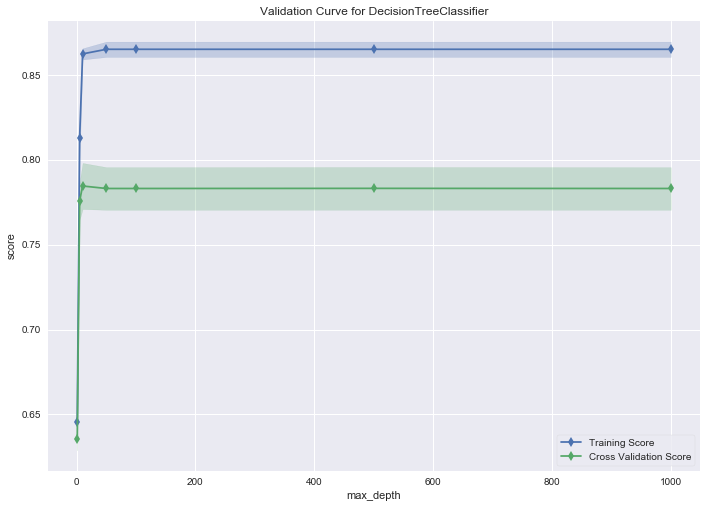

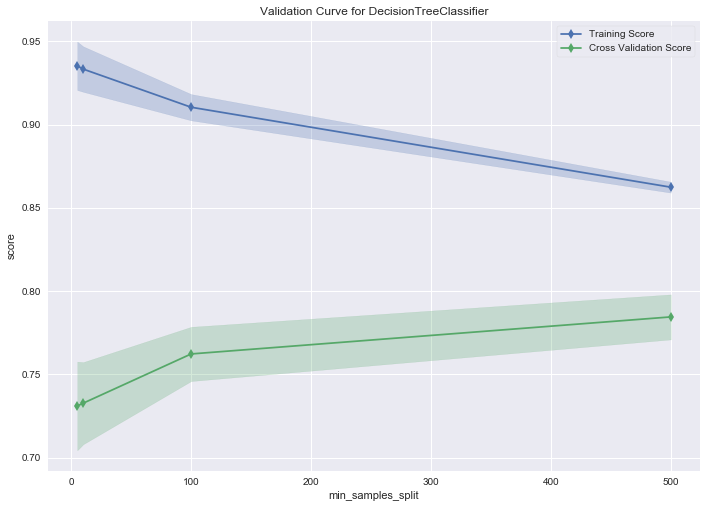

In [65]:
from yellowbrick.model_selection import ValidationCurve

#Validation Curve
viz = ValidationCurve(gsv.best_estimator_, param_name="max_depth",param_range=depth, cv=tscv, scoring="roc_auc")
viz.fit(sent_train_vectors, y_train)
viz.poof()
viz = ValidationCurve(gsv.best_estimator_, param_name="min_samples_split",param_range=min_split, cv=tscv, scoring="roc_auc")
viz.fit(sent_train_vectors, y_train)
viz.poof()

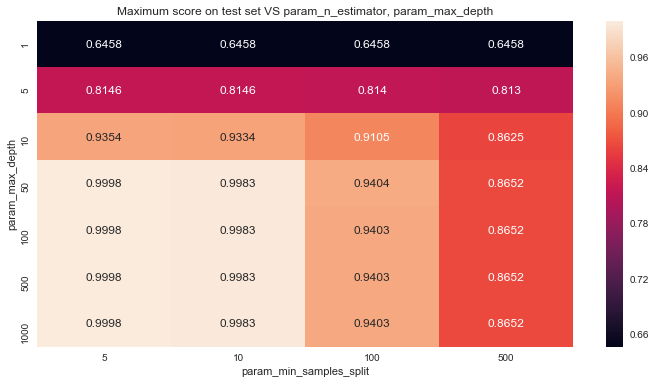

In [66]:
df_gridsearch = pd.DataFrame(gsv.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_min_samples_split']).max().unstack()[['mean_train_score']]
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)
title = 'Maximum score on test set VS param_n_estimator, param_max_depth'
fmt = 'png'
sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g');
plt.title(title);

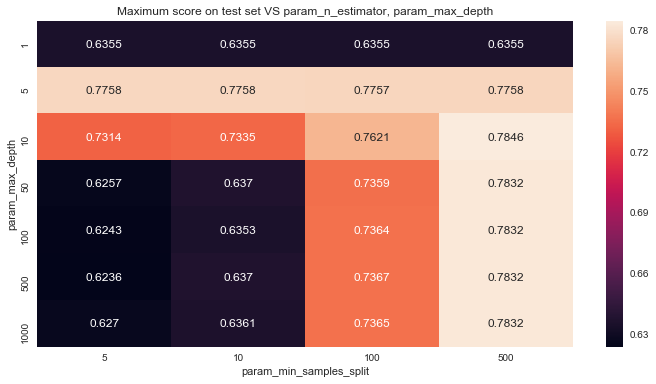

In [67]:
df_gridsearch = pd.DataFrame(gsv.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_min_samples_split']).max().unstack()[['mean_test_score']]
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)
title = 'Maximum score on test set VS param_n_estimator, param_max_depth'
fmt = 'png'
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');
plt.title(title);

ROC_AUC on test set: 0.805
Accuracy on test set: 86.970%
Precision on test set: 0.889
Recall on test set: 0.970
F1-Score on test set: 0.928


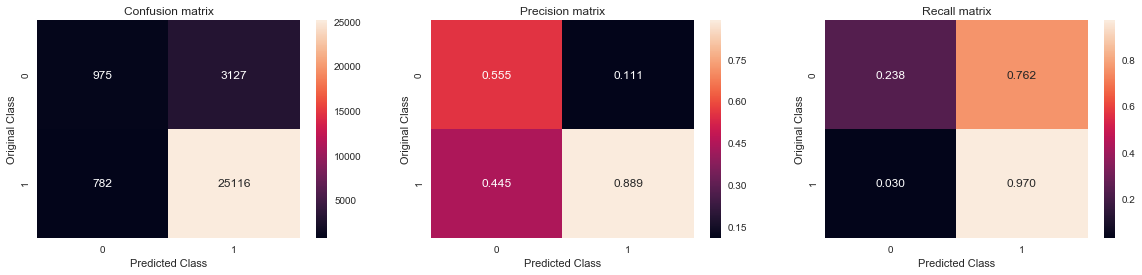

In [68]:
#Testing Accuracy on Test data
#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


clf = DecisionTreeClassifier(max_depth=10,min_samples_split=500)
clf.fit(sent_train_vectors,y_train)
y_pred = clf.predict(sent_test_vectors)
y_prob = clf.predict_proba(sent_test_vectors)


print("ROC_AUC on test set: %0.3f" % roc_auc_score(y_test, y_prob[:,1]))
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

#### [4.4.1.2] TFIDF weighted W2v

In [69]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer(ngram_range=(1,1))
tf_idf_matrix = model.fit_transform(data_preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [70]:
# TF-IDF weighted Word2Vec on Train data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

train_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_train_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 70000/70000 [1:15:34<00:00, 15.44it/s]


In [71]:
# TF-IDF weighted Word2Vec on Test data

test_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_test_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 30000/30000 [30:14<00:00, 17.20it/s] 


In [72]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

depth=[1,5,10,50,100,500,1000]
min_split=[5,10,100,500]
clf = DecisionTreeClassifier(class_weight='balanced')
param_grid = {'max_depth': depth,'min_samples_split': min_split}
tscv = TimeSeriesSplit(n_splits=5) #For time based splitting

gsv = GridSearchCV (clf,param_grid,cv=tscv,verbose=1,scoring='roc_auc',n_jobs=-1)
gsv.fit(train_tfidf_sent_vectors,y_train)
cv_scores = gsv.cv_results_['mean_test_score']

print("The best hyperparameter is : ",gsv.best_params_)
print("The best accuracy is : %.2f%%"%(gsv.best_score_*100))

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  9.1min finished


The best hyperparameter is :  {'max_depth': 10, 'min_samples_split': 500}
The best accuracy is : 75.14%


In [73]:
gsv.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

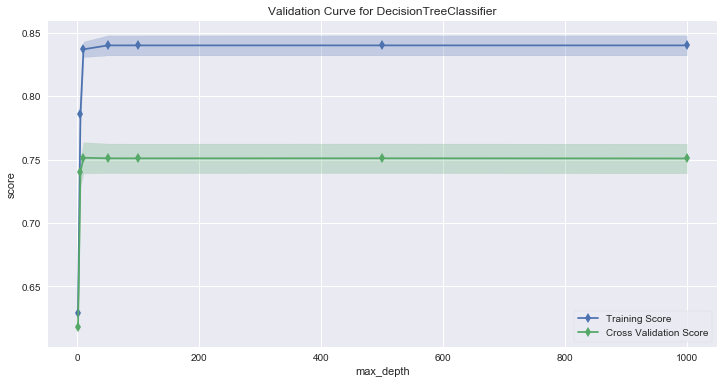

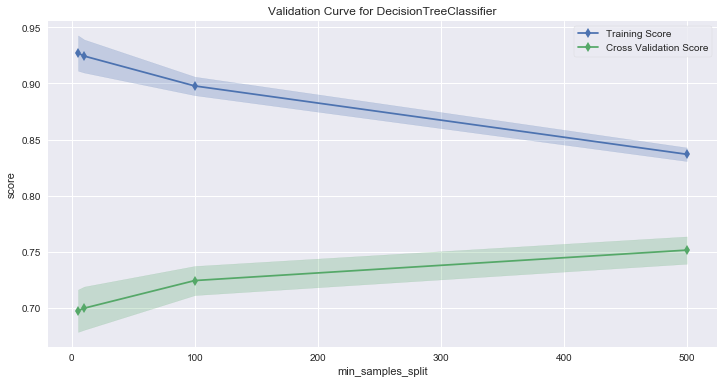

In [74]:
from yellowbrick.model_selection import ValidationCurve

#Validation Curve
viz = ValidationCurve(gsv.best_estimator_, param_name="max_depth",param_range=depth, cv=tscv, scoring="roc_auc")
viz.fit(train_tfidf_sent_vectors, y_train)
viz.poof()
viz = ValidationCurve(gsv.best_estimator_, param_name="min_samples_split",param_range=min_split, cv=tscv, scoring="roc_auc")
viz.fit(train_tfidf_sent_vectors, y_train)
viz.poof()

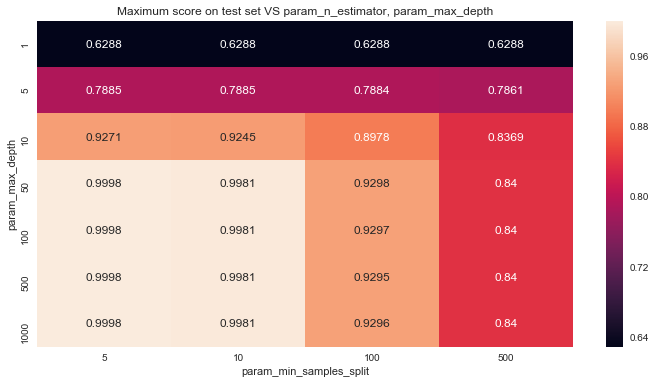

In [75]:
df_gridsearch = pd.DataFrame(gsv.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_min_samples_split']).max().unstack()[['mean_train_score']]
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)
title = 'Maximum score on test set VS param_n_estimator, param_max_depth'
fmt = 'png'
sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g');
plt.title(title);

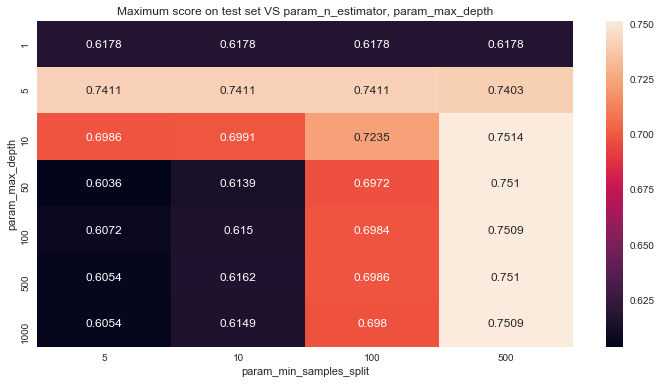

In [76]:
df_gridsearch = pd.DataFrame(gsv.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_min_samples_split']).max().unstack()[['mean_test_score']]
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)
title = 'Maximum score on test set VS param_n_estimator, param_max_depth'
fmt = 'png'
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');
plt.title(title);

ROC_AUC on test set: 0.805
Accuracy on test set: 86.980%
Precision on test set: 0.889
Recall on test set: 0.970
F1-Score on test set: 0.928


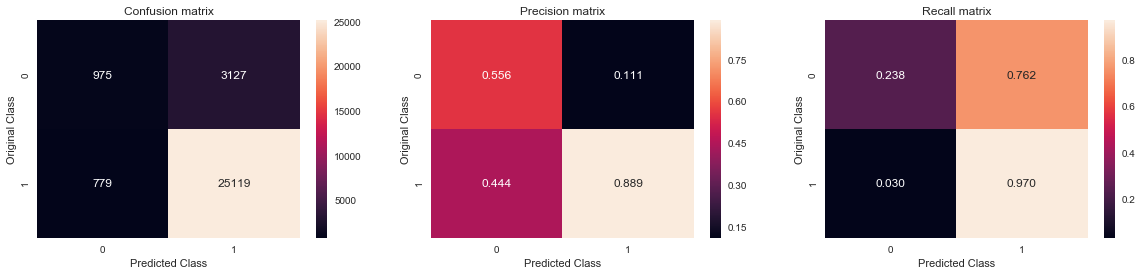

In [77]:
#Testing Accuracy on Test data
#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


clf = DecisionTreeClassifier(max_depth=10,min_samples_split=500)
clf.fit(sent_train_vectors,y_train)
y_pred = clf.predict(sent_test_vectors)
y_prob = clf.predict_proba(sent_test_vectors)


print("ROC_AUC on test set: %0.3f" % roc_auc_score(y_test, y_prob[:,1]))
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

In [78]:
from prettytable import PrettyTable    
x = PrettyTable()
 
x.field_names = ["Featurization", "Max. Depth","Min. sample split","ROC-AUC","F1-Score", "Accuracy"]
 
x.add_row(["BOW", 50,500,0.832, 0.930, 87.467]) 
x.add_row(["BOW - Bigram",50,500,0.838, 0.933, 87.937]) 
x.add_row(["TF-IDF",50,500,0.819, 0.930, 87.617]) 
x.add_row(["Avg-W2VEC", 10,500,0.805, 0.928, 86.970]) 
x.add_row(["TF-IDF W2V", 10,500,0.805, 0.928, 86.980]) 

print('\t\tDecision Tree')
print(x)

		Decision Tree
+---------------+------------+-------------------+---------+----------+----------+
| Featurization | Max. Depth | Min. sample split | ROC-AUC | F1-Score | Accuracy |
+---------------+------------+-------------------+---------+----------+----------+
|      BOW      |     50     |        500        |  0.832  |   0.93   |  87.467  |
|  BOW - Bigram |     50     |        500        |  0.838  |  0.933   |  87.937  |
|     TF-IDF    |     50     |        500        |  0.819  |   0.93   |  87.617  |
|   Avg-W2VEC   |     10     |        500        |  0.805  |  0.928   |  86.97   |
|   TF-IDF W2V  |     10     |        500        |  0.805  |  0.928   |  86.98   |
+---------------+------------+-------------------+---------+----------+----------+


# Conclusion

1) The Best ROC_AUC score was of BOW(bi-gram) featurization technique with max depth of 50 and min sample split of 500. 

2) BOW (bigram) Featurization(max_depth=50) gave the accuracy of 87.937% and  F1-score of 0.933.

3) We dont expect the model to perform well because Decision tree does not perform well with high features.